In [ ]:
%pip install fastf1
%pip install scikit-learn
%pip install pandas
%pip install joblib
%pip install tdqm

In [ ]:
import numpy as np
import pandas as pd

import argparse

import fastf1 as f1
from fastf1.core import Laps

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

## Define functions

### Clean driver names

In [ ]:
def clean_driver_name(driver_name: str) -> str:
    """
    Clean driver names by removing any unwanted characters and handling specific variations.
    """
    if pd.isna(driver_name):
        return driver_name
    cleaned_name = (driver_name.replace('.', '').replace('-', ' ').strip()
                    .replace('Ã©', 'é').replace('Ã¶', 'ö'))

    # Use a dictionary for specific driver name mappings
    name_mapping = {
        'Andrea Kimi Antonelli': 'Kimi Antonelli',
        'Kimi Andrea Antonelli': 'Kimi Antonelli', # Add another possible variation
        'Liam Lawson': 'Liam Lawson', # Explicit mapping
        'Yuki Tsunoda': 'Yuki Tsunoda', # Explicit mapping
        # Add more mappings here if other variations are found
    }

    # Check if the cleaned name is in the mapping, otherwise return the cleaned name
    return name_mapping.get(cleaned_name, cleaned_name)

### Non-ambiguous format for each session at each GP
(ie. "Dutch Grand Prix:FP1", "Dutch Grand Prix:Q", "Dutch Grand Prix:R")

In [ ]:
def session_key(grand_prix: str, session_name: str):
    return f"{grand_prix}:{session_name}"

### Safe division
(if division by 0 then return np.nan to not damage dataframe)

In [ ]:
def safe_div(a, b):
    """
    Return np.nan if division by zero
    """
    try:
        return float(a) / float(b) if (b not in [0, None, np.nan]) else np.nan
    except:
        return np.nan

### Load past race results to account for in ML model

In [ ]:
def load_past_race_results(year: int, gp_name: str) -> pd.DataFrame:
    """
    Load past race results for a given year and grand prix name.
    """
    ses = f1.get_session(year, gp_name, 'R')
    ses.load(laps=True, telemetry=False, weather=False)
    res = ses.results

    print("\n--- Columns in past race results ---")
    print(res.columns)

    # Check if essential columns exist before proceeding
    required_cols = ['FullName', 'TeamName', 'Position', 'Status']
    if not all(col in res.columns for col in required_cols):
        print(f"Missing essential columns in race results for {gp_name}. Available columns: {res.columns.tolist()}")
        return pd.DataFrame(columns=['Driver', 'Team', 'Position', 'Status'])

    res = res.assign(Driver=res['FullName'].apply(clean_driver_name),
                     Team=res['TeamName'])

    # Select only relevant columns to avoid issues with missing columns later
    return res[['Driver', 'Team', 'Position', 'Status']]

### Load data for qualifying session results **to account for grid positions** (once available)

In [ ]:
def load_qualifying_results(year: int, gp_name: str) -> pd.DataFrame:
    """
    Load qualifying results for the Azerbaijan Grand Prix from a local file.

    Args:
        year: The year of the race (currently not used for local file loading).
        gp_name: The name of the grand prix (used for constructing file paths - expected to be "Azerbaijan Grand Prix").

    Returns:
        A pandas DataFrame containing the qualifying results with 'Driver', 'Team', and 'GridPosition'.
    """
    # Use the hardcoded file path for Azerbaijan Grand Prix Qualifying Results
    file_path = '/content/F1 Azerbaijan Qualifying Results.txt'
    print(f"Attempting to load qualifying results from: {file_path}")

    try:
        # Read the entire file to process it manually
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        # Find the start of the results table
        start_line = None
        for i, line in enumerate(lines):
            if "POS | NO. | DRIVER" in line:
                start_line = i + 2  # Skip the header and separator line
                break

        if start_line is None:
            print("Could not find the results table in the file.")
            return pd.DataFrame(columns=['Driver', 'Team', 'GridPosition'])

        # Parse the results data
        results_data = []
        for line in lines[start_line:]:
            line = line.strip()
            # Stop when we hit a section break or empty line
            if not line or line.startswith('=') or line.startswith('DISQUALIFIED'):
                break

            # Skip lines that don't contain result data
            if '|' not in line:
                continue

            # Split by pipe and clean up
            parts = [part.strip() for part in line.split('|')]

            # We expect: POS | NO. | DRIVER | TEAM | Q1 TIME | Q2 TIME | Q3 TIME | LAPS
            if len(parts) >= 4:
                try:
                    pos = int(parts[0])
                    driver = parts[2]
                    team = parts[3]

                    results_data.append({
                        'GridPosition': pos,
                        'Driver': driver,
                        'Team': team
                    })
                except (ValueError, IndexError) as e:
                    print(f"Skipping malformed line: {line} - Error: {e}")
                    continue

        # Create DataFrame
        q = pd.DataFrame(results_data)

        if q.empty:
            print("No qualifying results data found in the file.")
            return pd.DataFrame(columns=['Driver', 'Team', 'GridPosition'])

        # Clean driver names
        q['Driver'] = q['Driver'].apply(clean_driver_name)

        print(f"Successfully loaded {len(q)} qualifying results.")
        return q[['Driver', 'Team', 'GridPosition']]

    except FileNotFoundError:
        print(f"Error: Qualifying results file not found at {file_path}.")
        return pd.DataFrame(columns=['Driver', 'Team', 'GridPosition'])
    except Exception as e:
        print(f"An error occurred while processing qualifying results from {file_path}: {e}")
        return pd.DataFrame(columns=['Driver', 'Team', 'GridPosition'])

In [ ]:
def load_azerbaijan_historical_results(drivers: list) -> pd.DataFrame:
    """
    Load historical Azerbaijan Grand Prix results for 2023 and 2024 for a list of drivers.

    Args:
        drivers: A list of driver names to filter the results by.

    Returns:
        A pandas DataFrame containing the historical results for the specified drivers
        at the Azerbaijan Grand Prix in 2023 and 2024.
    """
    azerbaijan_results = []
    years = [2021, 2022, 2023, 2024]
    gp_name = "Azerbaijan Grand Prix"

    for year in years:
        try:
            ses_race = f1.get_session(year, gp_name, 'R')
            ses_race.load(laps=False, telemetry=False, weather=False)
            res = ses_race.results

            # Check if essential columns exist before proceeding
            required_cols = ['FullName', 'TeamName', 'Position', 'Status']
            if not all(col in res.columns for col in required_cols):
                print(f"Missing essential columns in race results for {gp_name} {year}. Available columns: {res.columns.tolist()}")
                continue

            df = res.assign(Driver=res['FullName'].apply(clean_driver_name),
                            Team=res['TeamName'])

            df = df[df['Driver'].isin(drivers)].copy() # Filter by the provided driver list

            df['Position'] = pd.to_numeric(df['Position'], errors='coerce')
            df['finish_ok'] = (~df['Status'].fillna('').str.contains('Retired|Disqualified|Not Classified|Did Not Finish', case=False)).astype(int)

            df['Year'] = year # Add year column to distinguish results
            df['GP'] = gp_name
            azerbaijan_results.append(df[['Driver', 'Team', 'Year', 'GP', 'Position', 'Status', 'finish_ok']])

        except Exception as e:
            print(f"An error occurred while processing data for {gp_name} {year}: {e}")
            continue

    if not azerbaijan_results:
        print(f"No historical Azerbaijan Grand Prix results found for years {years} for the specified drivers.")
        return pd.DataFrame()

    hist_azerbaijan = pd.concat(azerbaijan_results, ignore_index=True)
    return hist_azerbaijan

### Build season table of per-driver features leading to Azerbaijan Grand Prix

In [ ]:
def build_season_table(year: int, up_to_gp_name: str) -> pd.DataFrame:
    """
    Build a season table of per-driver features leading but up to the specified Grand Prix.
    """
    schedule = f1.get_event_schedule(year)

    # Use the hardcoded list of Grand Prix
    grand_prix_list = [
        "Australian Grand Prix",
        "Chinese Grand Prix",
        "Japanese Grand Prix",
        "Bahrain Grand Prix",
        "Saudi Arabian Grand Prix",
        "Miami Grand Prix",
        "Emilia Romagna Grand Prix",
        "Monaco Grand Prix",
        "Spanish Grand Prix",
        "Canadian Grand Prix",
        "Austrian Grand Prix",
        "British Grand Prix",
        "Belgian Grand Prix",
        "Hungarian Grand Prix",
        "Dutch Grand Prix",
        "Italian Grand Prix"
    ]

    # Load data for each of the previous completed races
    rows = []

    for gp in grand_prix_list:
        try:
            ses_race = f1.get_session(year, gp, 'R')
            ses_race.load(laps=True, telemetry=False, weather=False)
            res = ses_race.results

            # Check if essential columns exist before proceeding
            required_cols = ['FullName', 'TeamName', 'Position', 'Status', 'GridPosition']
            if not all(col in res.columns for col in required_cols):
                print(f"Missing essential columns in race results for {gp}. Available columns: {res.columns.tolist()}")
                continue

            df = res.assign(Driver=res['FullName'].apply(clean_driver_name),
                            Team=res['TeamName'])

            df['Position'] = pd.to_numeric(df['Position'], errors='coerce')
            df['finish_ok'] = (~df['Status'].fillna('').str.contains('Retired|Disqualified|Not Classified|Did Not Finish', case=False)).astype(int)
            df['grid_pos'] = pd.to_numeric(df['GridPosition'], errors='coerce') # Use GridPosition directly

            df['GP'] = gp
            df['Date'] = ses_race.date # Add event date for chronological sorting
            rows.append(df[['Driver', 'Team', 'GP', 'Date', 'Position', 'Status', 'finish_ok', 'grid_pos']]) # Select relevant columns

        except Exception as e:
            print(f"An error occurred while processing data for {gp}: {e}")
            continue
    if not rows:
        raise RuntimeError("Could not assemble any past race results. Try a different year or check FastF1 availability.")

    hist = pd.concat(rows, ignore_index=True)
    # hist = hist.sort_values(by=['Driver', 'Date']).reset_index(drop=True) # Remove sorting from here, will sort in build_training_data

    # Aggregate data by driver and GP
    agg = (hist.groupby(['Driver', 'Team'])
           .agg(
               num_races = ('GP', 'size'),
               mean_finish_pos = ('Position', 'mean'),
               median_finish_pos = ('Position', 'median'),
               best_finish_pos = ('Position', 'min'),
               finish_rate = ('finish_ok', 'mean'),
               mean_grid_pos = ('grid_pos', 'mean'),
               median_grid_pos = ('grid_pos', 'median'),
           )
           .reset_index())

    # Normalise feature scale using log transforms
    agg['form_score'] = (1/agg['mean_finish_pos']).replace([np.inf, -np.inf], np.nan)  # Invert finish position
    agg['qual_form'] = (1/agg['mean_grid_pos']).replace([np.inf, -np.nan], np.nan)  # Invert grid position

    return agg, hist

## Training

### Build training data function
(labeled dataset from past races the model will learn from)

In [ ]:
def build_training_data(season_agg: pd.DataFrame, hist: pd.DataFrame, mode: str, free_practice: pd.DataFrame, azerbaijan_hist: pd.DataFrame = None) -> pd.DataFrame:
    """
    One training row per (driver, past race) with features form season to date

    Args:
        season_agg: A pandas DataFrame containing the aggregated data for the current season
                    (in the current flow, this is often the pred_df from run_prediction_with_fallback).
        hist_data: A pandas DataFrame containing the historical data for the previous seasons.
        azerbaijan_hist: Optional. A pandas DataFrame containing historical Azerbaijan GP results.
    """

    hist_sorted = hist.sort_values(by=['Driver', 'Date']).copy() # Sort by Driver and Date
    feats = []
    driver_groups = hist_sorted.groupby('Driver')

    for driver, group in driver_groups:
        group = group.reset_index(drop=True)
        for i in range(len(group)):
            row = group.iloc[i]

            # Calculate statistics based on all races *up to and including* the current race
            races_up_to_current = group.iloc[:i+1]

            if len(races_up_to_current) == 0:
                continue

            tmp = {
                'Driver': driver,
                'Team': row['Team'],
                'GP': row['GP'],
                'y_finish_pos': row['Position'], # To be predicted!!!

                # stats up to and including the current race
                'num_races': len(races_up_to_current), # Count of races *up to and including* the current one
                'mean_finish_up_to_current': races_up_to_current['Position'].mean(),
                'median_finish_up_to_current': races_up_to_current['Position'].median(),
                'best_finish_up_to_current': races_up_to_current['Position'].min(),
                'finish_rate_up_to_current': races_up_to_current['finish_ok'].mean(),
            }

            # Conditionally add grid position features from historical data if 'grid_pos' column exists
            if 'grid_pos' in races_up_to_current.columns:
                 tmp['mean_grid_pos_up_to_current'] = races_up_to_current['grid_pos'].mean()
                 tmp['median_grid_pos_up_to_current'] = races_up_to_current['grid_pos'].median()
            else:
                 tmp['mean_grid_pos_up_to_current'] = np.nan
                 tmp['median_grid_pos_up_to_current'] = np.nan

            feats.append(tmp)

    train = pd.DataFrame(feats)
    print("\n--- Initial Training Data ---")
    display(train) # Display full dataframe


    # Merge form_score and qual_form from season_agg into train_df
    # Ensure we are merging the correct 'qual_form' which is based on historical season data
    # Also merge azerbaijan_form_score from season_agg (which is pred_df)
    cols_to_merge_from_season_agg = ['Driver', 'form_score', 'qual_form']
    if 'azerbaijan_form_score' in season_agg.columns:
        cols_to_merge_from_season_agg.append('azerbaijan_form_score')

    train = train.merge(season_agg[cols_to_merge_from_season_agg], on='Driver', how='left')

    print("\n--- Training Data after Merging season_agg Features ---")
    display(train.head())


    # Merge historical Azerbaijan GP results if provided (raw aggregated stats)
    # This merge might be redundant if azerbaijan_form_score is calculated from these in assemble_prediction_frame
    # but keeping it for now based on previous code logic.
    if azerbaijan_hist is not None and not azerbaijan_hist.empty:
        azerbaijan_agg = (azerbaijan_hist.groupby('Driver')
                         .agg(
                             azerbaijan_avg_finish = ('Position', 'mean'),
                             azerbaijan_median_finish = ('Position', 'median'),
                             azerbaijan_best_finish = ('Position', 'min'),
                             azerbaijan_finish_rate = ('finish_ok', 'mean')
                         )
                         .reset_index())

        train = train.merge(azerbaijan_agg, on='Driver', how='left')
        print("\n--- Training Data after Merging Azerbaijan Historical Results (Aggregated) ---")
        display(train.head())


    # Merge optional free practice data (currently not used in training)
    # if free_practice is not None and len(free_practice) > 0:
    #     ... (logic for merging FP data if needed for training)

    # Explicitly remove 'GridPosition' column if it exists, as it's for prediction only
    if 'GridPosition' in train.columns:
        train = train.drop(columns=['GridPosition'])
        print("\n--- Training Data after Removing GridPosition Column ---")
        display(train.head())


    # If mode is not 'with-grid', exclude grid information and qual_form
    if mode != 'with-grid':
        grid_cols_to_drop = [col for col in train.columns if 'grid_pos' in col or 'grid_pos_up_to_current' in col or 'qual_form' in col]
        if grid_cols_to_drop:
            train = train.drop(columns=grid_cols_to_drop)
            print("\n--- Training Data after Removing Grid Position Features (mode != 'with-grid') ---")
            display(train.head())


    # Drop rows with NaN values in the target variable
    train = train.dropna(subset=['y_finish_pos'])
    print("\n--- Final Training Data (after dropping NaNs in y_finish_pos) ---")
    display(train.head())
    return train

In [ ]:
def calculate_azerbaijan_form(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates a composite 'azerbaijan_form_score' based on historical Azerbaijan GP results.

    Args:
        df: DataFrame containing historical Azerbaijan GP results for each driver
            with columns like 'azerbaijan_avg_finish', 'azerbaijan_median_finish',
            'azerbaijan_best_finish', 'azerbaijan_finish_rate'.

    Returns:
        DataFrame with an added 'azerbaijan_form_score' column.
    """
    # Ensure required columns exist, fill missing values with a neutral value (e.g., median or mean of the dataset)
    # For simplicity, we will fill with median for now. Consider a more sophisticated imputation if needed.
    required_cols = ['azerbaijan_avg_finish', 'azerbaijan_median_finish', 'azerbaijan_best_finish', 'azerbaijan_finish_rate']
    for col in required_cols:
        if col not in df.columns:
            df[col] = np.nan # Add missing columns with NaN

    # Impute missing values with the median of the respective column before calculation
    for col in required_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val if pd.notna(median_val) else df[col].mean(), inplace=True) # Fallback to mean if median is NaN

    # Define weights for each metric (these can be adjusted based on domain knowledge or experimentation)
    # Lower finish position is better, so we might want to invert or use a reciprocal for avg/median/best finish
    # Higher finish rate is better.
    # Example weighting: giving more weight to best finish and finish rate
    weight_avg = 0.25
    weight_median = 0.25
    weight_best = 0.3
    weight_finish_rate = 0.2

    # Calculate a composite score. Inverting finish positions so lower values contribute positively to the score.
    # Add a small epsilon to avoid division by zero if a position is exactly 0 (though positions are usually >= 1)
    epsilon = 1e-6
    df['azerbaijan_form_score'] = (
        weight_avg * (1 / (df['azerbaijan_avg_finish'] + epsilon)) +
        weight_median * (1 / (df['azerbaijan_median_finish'] + epsilon)) +
        weight_best * (1 / (df['azerbaijan_best_finish'] + epsilon)) +
        weight_finish_rate * df['azerbaijan_finish_rate']
    )

    # Normalize the score if desired (e.g., min-max scaling or z-score)
    # For now, we'll keep it as is.

    return df[['Driver', 'azerbaijan_form_score']]

### Prediction Frame
(builds input for the model to predict the upcoming race)

In [ ]:
def assemble_prediction_frame(year: int, gp_name: str, mode: str) -> pd.DataFrame:
    """
    Create the feature frame for the upcoming race.
    """

    season_agg, hist = build_season_table(year, gp_name)
    print("\n--- Season Aggregated Data ---")
    display(season_agg) # Display full dataframe
    print("\n--- Historical Race Data ---")
    display(hist.head())

    # Drivers that will participate in the upcoming race (unique drivers from the season)
    roster_drivers = hist['Driver'].unique().tolist()

    # Remove Jack Doohan from the roster if he is present
    if 'Jack Doohan' in roster_drivers:
        roster_drivers.remove('Jack Doohan')

    # Get the most recent team for each driver from the historical data
    latest_teams = hist.sort_values(by='Date').groupby('Driver')['Team'].last().reset_index()
    roster = latest_teams[latest_teams['Driver'].isin(roster_drivers)].copy()
    print("\n--- Roster of Drivers for Upcoming Race (Unique Drivers with Latest Team) ---")
    display(roster)


    # Load qualifying results for the upcoming race if mode is 'with-grid'
    qualifying_results = None
    if mode == 'with-grid':
        qualifying_results = load_qualifying_results(year, gp_name)
        print("\n--- Qualifying Results ---")
        display(qualifying_results.head())

    # Load historical Azerbaijan Grand Prix results if predicting for Azerbaijan Grand Prix
    azerbaijan_hist = None
    if gp_name == "Azerbaijan Grand Prix":
         azerbaijan_hist = load_azerbaijan_historical_results(roster_drivers)
         print("\n--- Historical Azerbaijan Grand Prix Results ---")
         display(azerbaijan_hist.head())


    # Calculate "up to current" features for the prediction dataframe
    pred_features = []
    driver_groups = hist[hist['Driver'].isin(roster_drivers)].groupby('Driver') # Filter hist to include only roster drivers
    for driver, group in driver_groups:
        # Get the data for this driver up to the last race in the historical data
        races_up_to_last = group.copy()

        if len(races_up_to_last) == 0:
            continue

        tmp = {
            'Driver': driver,
            # 'Team': group['Team'].iloc[-1], # Team is now handled by merging with latest_teams
            'num_races': len(races_up_to_last),
            'mean_finish_up_to_current': races_up_to_last['Position'].mean(),
            'median_finish_up_to_current': races_up_to_last['Position'].median(),
            'best_finish_up_to_current': races_up_to_last['Position'].min(),
            'finish_rate_up_to_current': races_up_to_last['finish_ok'].mean(),
        }

        if 'grid_pos' in races_up_to_last.columns:
             tmp['mean_grid_pos_up_to_current'] = races_up_to_last['grid_pos'].mean()
             tmp['median_grid_pos_up_to_current'] = races_up_to_last['grid_pos'].median()
        else:
             tmp['mean_grid_pos_up_to_current'] = np.nan
             tmp['median_grid_pos_up_to_current'] = np.nan

        pred_features.append(tmp)

    pred = pd.DataFrame(pred_features)
    # Merge with roster to get the latest team and ensure unique drivers
    pred = pred.merge(roster, on='Driver', how='left')
    print("\n--- Prediction Frame with Up to Current Features and Latest Team ---")
    display(pred.head())


    # Add features from the season table (form_score and qual_form are already in season_agg)
    # Select the latest team's aggregated stats for each driver from season_agg
    season_agg_latest_team = season_agg.sort_values(by='num_races').groupby('Driver').tail(1).reset_index(drop=True)
    # Merge on Driver only, as Team is now handled by the roster merge
    pred = pred.merge(season_agg_latest_team[['Driver', 'form_score', 'qual_form']],
                      on='Driver', how='left')
    print("\n--- Prediction Frame after Merging form_score and qual_form ---")
    display(pred)

    # Merge historical Azerbaijan GP results if available and calculate azerbaijan_form_score
    if azerbaijan_hist is not None and not azerbaijan_hist.empty:
        # Calculate average finish position at Azerbaijan GP for each driver
        azerbaijan_agg = (azerbaijan_hist.groupby('Driver')
                         .agg(
                             azerbaijan_avg_finish = ('Position', 'mean'),
                             azerbaijan_median_finish = ('Position', 'median'),
                             azerbaijan_best_finish = ('Position', 'min'),
                             azerbaijan_finish_rate = ('finish_ok', 'mean')
                         )
                         .reset_index())

        # Merge Azerbaijan aggregated stats into the prediction data
        pred = pred.merge(azerbaijan_agg, on='Driver', how='left')

        # Calculate the composite azerbaijan_form_score directly after merging aggregated data
        # Ensure required columns exist before calculating the score
        required_azerbaijan_cols = ['azerbaijan_avg_finish', 'azerbaijan_median_finish', 'azerbaijan_best_finish', 'azerbaijan_finish_rate']
        for col in required_azerbaijan_cols:
            if col not in pred.columns:
                pred[col] = np.nan # Add missing columns with NaN

        # Impute missing values in aggregated columns with the median before calculating the score
        for col in required_azerbaijan_cols:
             if pred[col].isnull().any():
                  median_val = pred[col].median()
                  pred[col] = pred[col].fillna(median_val if pd.notna(median_val) else pred[col].mean())


        # Define weights for each metric (these can be adjusted based on domain knowledge or experimentation)
        weight_avg = 0.25
        weight_median = 0.25
        weight_best = 0.3
        weight_finish_rate = 0.2
        epsilon = 1e-6 # Add a small epsilon to avoid division by zero

        pred['azerbaijan_form_score'] = (
            weight_avg * (1 / (pred['azerbaijan_avg_finish'] + epsilon)) +
            weight_median * (1 / (pred['azerbaijan_median_finish'] + epsilon)) +
            weight_best * (1 / (pred['azerbaijan_best_finish'] + epsilon)) +
            weight_finish_rate * pred['azerbaijan_finish_rate']
        )

        # Fill NaN in the newly calculated azerbaijan_form_score if any arise (should be handled by imputation above)
        if pred['azerbaijan_form_score'].isnull().any():
             median_score = pred['azerbaijan_form_score'].median()
             pred['azerbaijan_form_score'] = pred['azerbaijan_form_score'].fillna(median_score if pd.notna(median_score) else pred['azerbaijan_form_score'].mean())


        print("\n--- Prediction Frame after Merging Azerbaijan Historical Results and Calculating Form Score ---")
        display(pred.head())


    # Add features from the qualifying results (if available and mode is with-grid)
    if qualifying_results is not None and len(qualifying_results) > 0 and mode == 'with-grid':
        # Merge qualifying results into the prediction frame
        pred = pred.merge(qualifying_results[['Driver', 'GridPosition']], on='Driver', how='left', suffixes=('', '_upcoming'))
        pred['grid_pos_upcoming'] = pd.to_numeric(pred['GridPosition'], errors='coerce')
        pred = pred.drop(columns=['GridPosition']) # Drop the original GridPosition column
        print("\n--- Prediction Frame after Merging Qualifying Results (Upcoming) ---")
        display(pred.head())
    elif mode == 'with-grid':
        print("Warning: Mode is 'with-grid' but no qualifying results were loaded.")
        # Add a column of NaNs for 'grid_pos_upcoming' if qualifying results were not loaded
        pred['grid_pos_upcoming'] = np.nan


    return pred, hist, qualifying_results # Return qualifying_results instead of free_practice

### Fit Model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def fit_model(train_df: pd.DataFrame, model_type: str):
    """
    Fit a specified model to the training data and evaluate its performance.
    Also returns the residuals from the cross-validation predictions.
    """
    y_train = train_df['y_finish_pos']

    # Define the base feature columns
    feature_columns = [c for c in train_df.columns if c not in ['Driver', 'Team', 'GP', 'y_finish_pos', 'mean_grid_pos_prev_races', 'median_grid_pos_prev_races']]

    # Add Azerbaijan historical features if they exist in the training data
    azerbaijan_hist_cols = ['azerbaijan_avg_finish', 'azerbaijan_median_finish', 'azerbaijan_best_finish', 'azerbaijan_finish_rate']
    for col in azerbaijan_hist_cols:
        if col in train_df.columns and col not in feature_columns:
            feature_columns.append(col)

    X_train = train_df[feature_columns].fillna(train_df[feature_columns].median()) # Impute NaN values with the median

    print("\n--- Feature columns for training ---")
    print(X_train.columns)

    # Using GroupKFold to account for drivers that raced multiple times
    groups = train_df['GP']
    cv = GroupKFold(n_splits=min(5, len(np.unique(groups))))
    oof = np.zeros(len(train_df))  # out-of-fold predictions (kind of like cross-validation)

    models = []
    for train_idx, valid_idx in cv.split(X_train, y_train, groups=groups):
        if model_type == 'GradientBoosting':
            model = GradientBoostingRegressor(random_state=42, n_estimators=600, learning_rate=0.03, max_depth=3, subsample=0.8)
        elif model_type == 'RandomForest':
            model = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=10, min_samples_split=5, min_samples_leaf=3) # Example hyperparameters for RF
        else:
            raise ValueError("Invalid model_type specified. Choose 'GradientBoosting' or 'RandomForest'.")

        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        oof[valid_idx] = model.predict(X_train.iloc[valid_idx]) # update the out-of-fold predictions
        models.append(model)

    # Evaluate the model
    mae = mean_absolute_error(y_train, oof)
    rmse = np.sqrt(mean_squared_error(y_train, oof))
    r2 = r2_score(y_train, oof)

    print(f"CV MAE ({model_type}): {mae:.3f} positions")
    print(f"CV RMSE ({model_type}): {rmse:.3f} positions")
    print(f"CV R-squared ({model_type}): {r2:.3f}")

    # Plot predicted vs actual finish positions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, oof, alpha=0.5)
    plt.xlabel("Actual Finish Position")
    plt.ylabel("Predicted Finish Position")
    plt.title(f"Predicted vs. Actual Finish Positions ({model_type} - Cross-Validation)")
    plt.grid(True)
    plt.show()

    # Calculate residuals
    residuals = y_train - oof

    return models, mae, feature_columns, residuals

### Standings from simulation
(convert simulation's predicted positions into ordering)

In [ ]:
def convert_sim_preds_to_standings(pred_df: pd.DataFrame, sims: np.ndarray):
    n_sims, n = sims.shape
    drivers = pred_df['Driver'].tolist()
    teams = pred_df['Team'].tolist()

    # Create dictionaries to store the standings for each simulation
    win = dict.fromkeys(drivers, 0)
    podium = dict.fromkeys(drivers, 0)
    points = dict.fromkeys(drivers, 0)
    avg_pos = dict.fromkeys(drivers, 0.0)
    # exp_pos = dict.fromkeys(drivers, 0.0) # Remove ExpPos calculation

    # Points system
    POINTS_SYS = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1]

    for s in range(n_sims):
        order = np.argsort(sims[s, :]) # lower position = better
        for i, pos_idx in enumerate(order, start = 0): # Iterate through indices of sorted positions
            driver = drivers[pos_idx]
            predicted_pos = i + 1 # Simulated finish position (starting from 1)

            avg_pos[driver] += sims[s, pos_idx]

            if predicted_pos == 1:
                win[driver] += 1
            if predicted_pos <= 3:
                podium[driver] += 1
            if predicted_pos <= 10:
                points[driver] += POINTS_SYS[predicted_pos - 1] # Use predicted_pos - 1 as index


    # Summarise results visually
    out = []
    for driver, team in zip(drivers, teams):
        sims_counts = float(n_sims)
        out.append({
            'Driver': driver,
            'Team': team,
            'AvgPredPos': avg_pos[driver] / sims_counts,
            'Win%': 100.0*win[driver] / sims_counts,
            'Podium%': 100.0*podium[driver] / sims_counts,
            'Points%': 100.0*points[driver] / sims_counts,
            # 'ExpPos': exp_pos[driver] / sims_counts # Remove ExpPos from output
        })

    df = pd.DataFrame(out)
    df = df.sort_values(by=['AvgPredPos']).reset_index(drop=True)
    return df

In [ ]:
# Test correct loading of past results
import fastf1 as f1

grand_prix_list = [
    "Australian Grand Prix",
    "Chinese Grand Prix",
    "Japanese Grand Prix",
    "Bahrain Grand Prix",
    "Saudi Arabian Grand Prix",
    "Miami Grand Prix",
    "Emilia Romagna Grand Prix",
    "Monaco Grand Prix",
    "Spanish Grand Prix",
    "Canadian Grand Prix",
    "Austrian Grand Prix",
    "British Grand Prix",
    "Belgian Grand Prix",
    "Hungarian Grand Prix",
    "Dutch Grand Prix",
    "Italian Grand Prix"
]

year = 2025

print(f"Testing data availability for {year} season:")
for gp in grand_prix_list:
    try:
        session = f1.get_session(year, gp, 'R')
        session.load(laps=False, telemetry=False, weather=False)
        print(f"Data available for {gp}")
    except Exception as e:
        print(f"Data not available for {gp}: {e}")

core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']


Testing data availability for 2025 season:
Data available for Australian Grand Prix


core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Rac

Data available for Chinese Grand Prix
Data available for Japanese Grand Prix
Data available for Bahrain Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core        

Data available for Saudi Arabian Grand Prix
Data available for Miami Grand Prix
Data available for Emilia Romagna Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core  

Data available for Monaco Grand Prix
Data available for Spanish Grand Prix
Data available for Canadian Grand Prix


INFO:fastf1.fastf1.core:Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:

Data available for Austrian Grand Prix
Data available for British Grand Prix
Data available for Belgian Grand Prix


req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Dutch Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:47:38.638' in Ergastresponse.
req            INFO 	Using cached data for race_control_messag

Data available for Hungarian Grand Prix
Data available for Dutch Grand Prix
Data available for Italian Grand Prix


# Main Code

In [ ]:
def run_prediction_with_fallback(year, grand_prix, mode='with-grid', n_sims=3000, race_only=False, model_type='GradientBoosting'):
    """
    Runs the race prediction model, with a fallback to the previous year if the requested year's data is not available.
    """
    try:
        print(f"Attempting to load data for year: {year}, up to Grand Prix: {grand_prix}")
        # Pass azerbaijan_hist to build_training_data
        pred_df, hist, fp = assemble_prediction_frame(year, grand_prix, mode)
        # Load historical Azerbaijan Grand Prix results again to pass to build_training_data if needed
        azerbaijan_hist_for_training = None
        if grand_prix == "Azerbaijan Grand Prix":
             azerbaijan_hist_for_training = load_azerbaijan_historical_results(pred_df['Driver'].tolist())


        train_df = build_training_data(pred_df, hist, mode, fp, azerbaijan_hist=azerbaijan_hist_for_training) # Pass azerbaijan_hist here
        models, mae, feature_cols, residuals = fit_model(train_df, model_type) # Get residuals from fit_model
        print(f"Successfully loaded data for {year}.")

    except RuntimeError as e:
        if "Could not assemble any past race results" in str(e):
            print(f"No completed races found for {year}. Falling back to {year - 1}.")
            try:
                year -= 1
                print(f"Attempting to load data for year: {year}, up to Grand Prix: {grand_prix}")
                # Load historical Azerbaijan Grand Prix results again for the fallback year
                azerbaijan_hist_for_training = None
                if grand_prix == "Azerbaijan Grand Prix":
                     # Need to determine the roster drivers for the fallback year first
                     # A simplified approach is to use the roster drivers from the original year,
                     # or rebuild the roster for the fallback year if necessary.
                     # For now, let's assume the roster is similar enough or handle potential NaNs.
                     # A more robust solution might rebuild the prediction frame for the fallback year entirely.
                     # For simplicity, let's reload historical Azerbaijan data for the fallback year.
                     fallback_pred_df, fallback_hist, fallback_fp = assemble_prediction_frame(year, grand_prix, mode)
                     azerbaijan_hist_for_training = load_azerbaijan_historical_results(fallback_pred_df['Driver'].tolist())
                     pred_df, hist, fp = fallback_pred_df, fallback_hist, fallback_fp # Use fallback data for prediction later


                train_df = build_training_data(pred_df, hist, mode, fp, azerbaijan_hist=azerbaijan_hist_for_training) # Pass azerbaijan_hist here
                models, mae, feature_cols, residuals = fit_model(train_df, model_type) # Get residuals from fit_model
                print(f"Successfully loaded data for {year}.")
            except Exception as fallback_e:
                print(f"Failed to load data for both {year + 1} and {year}: {fallback_e}")
                return None, None, None # Return None for pred_df, sims, and summary
        else:
            print(f"An unexpected error occurred: {e}")
            return None, None, None # Return None for pred_df, sims, and summary
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        return None, None, None # Return None for pred_df, sims, and summary


    # point preds (+ optional sims)
    # Select the features for prediction
    # Create a list of feature columns for prediction, mapping historical names to upcoming if needed
    feature_cols_for_prediction = []
    for col in feature_cols:
        if mode == 'with-grid' and col == 'grid_pos_historical' and 'grid_pos_upcoming' in pred_df.columns:
            feature_cols_for_prediction.append('grid_pos_upcoming')
        else:
            feature_cols_for_prediction.append(col)

    # Select columns from pred_df using the modified feature list
    try:
        Xp = pred_df[feature_cols_for_prediction].copy()
    except KeyError as e:
        print(f"Error selecting features for prediction: {e}")
        print(f"Feature columns from training: {feature_cols}")
        print(f"Feature columns for prediction attempt: {feature_cols_for_prediction}")
        print(f"Available columns in pred_df: {pred_df.columns.tolist()}")
        return None, None, None # Return None if feature selection fails


    # If grid_pos_historical was a training feature and grid_pos_upcoming was used for prediction, rename the column in Xp
    if mode == 'with-grid' and 'grid_pos_historical' in feature_cols and 'grid_pos_upcoming' in pred_df.columns:
         if 'grid_pos_upcoming' in Xp.columns: # Ensure the column was actually added
              Xp = Xp.rename(columns={'grid_pos_upcoming': 'grid_pos_historical'})
              print("\n--- Renamed grid_pos_upcoming to grid_pos_historical for prediction ---")


    Xp = Xp.fillna(Xp.median()) # Impute NaN values in prediction features

    base_pred = np.mean([m.predict(Xp) for m in models], axis=0)

    pred_df = pred_df.copy()
    pred_df['PredFinish'] = base_pred
    pred_df = pred_df.sort_values('PredFinish').reset_index(drop=True)

    # simulate results by sampling from residuals
    sims = np.zeros((n_sims, len(pred_df)))
    # Ensure residuals are not empty before sampling
    if len(residuals) > 0:
        for i in range(n_sims):
            sampled_residuals = np.random.choice(residuals, size=len(pred_df), replace=True)
            sims[i, :] = base_pred + sampled_residuals
            # Incorporate grid_pos_upcoming into simulated results if available and mode is with-grid
            if mode == 'with-grid' and 'grid_pos_upcoming' in pred_df.columns:
                # Ensure grid_pos_upcoming has no NaNs for this calculation
                # Use .loc to avoid FutureWarning
                pred_df_grid_pos = pred_df.loc[:, 'grid_pos_upcoming'].fillna(pred_df['grid_pos_upcoming'].median())
                sims[i, :] = np.maximum(sims[i, :] * 0.8 + pred_df_grid_pos * 0.2, 1)
            else:
                sims[i, :] = np.maximum(sims[i, :], 1) # Clip simulated positions at a minimum of 1

    else:
        print("No residuals available for simulation. Simulations will be based on base predictions only.")
        for i in range(n_sims):
             sims[i, :] = base_pred
             sims[i, :] = np.maximum(sims[i, :], 1)


    summary = convert_sim_preds_to_standings(pred_df, sims)

    # Always return pred_df, sims, and summary
    return pred_df, sims, summary

core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


Attempting to load qualifying results from: /content/F1 Azerbaijan Qualifying Results.txt
Successfully loaded 20 qualifying results.
Qualifying results loaded: True
Attempting to load data for year: 2025, up to Grand Prix: Azerbaijan Grand Prix


req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for race_control_messages


--- Season Aggregated Data ---


,Driver,Team,num_races,mean_finish_pos,median_finish_pos,best_finish_pos,finish_rate,mean_grid_pos,median_grid_pos,form_score,qual_form
0,Alexander Albon,Williams,16,9.875000,8.5,5.0,0.812500,10.812500,10.5,0.101266,0.092486
1,Carlos Sainz,Williams,16,13.000000,12.5,8.0,0.875000,11.875000,12.0,0.076923,0.084211
2,Charles Leclerc,Ferrari,16,6.687500,4.0,2.0,0.875000,5.062500,5.0,0.149533,0.197531
3,Esteban Ocon,Haas F1 Team,16,12.562500,13.0,5.0,0.937500,14.875000,15.5,0.079602,0.067227
4,Fernando Alonso,Aston Martin,16,12.312500,11.0,5.0,0.750000,10.500000,10.5,0.081218,0.095238
5,Franco Colapinto,Alpine,10,15.700000,15.5,11.0,1.000000,15.800000,16.0,0.063694,0.063291
6,Gabriel Bortoleto,Kick Sauber,16,14.062500,14.5,6.0,0.812500,13.750000,14.5,0.071111,0.072727
7,George Russell,Mercedes,16,4.750000,4.5,1.0,1.000000,4.562500,4.0,0.210526,0.219178
8,Isack Hadjar,Racing Bulls,16,11.500000,11.0,3.0,0.875000,10.187500,10.5,0.086957,0.098160
9,Jack Doohan,Alpine,6,16.333333,16.0,13.0,0.666667,15.500000,15.5,0.061224,0.064516



--- Historical Race Data ---


,Driver,Team,GP,Date,Position,Status,finish_ok,grid_pos
0,Lando Norris,McLaren,Australian Grand Prix,2025-03-16 04:00:00,1.0,Finished,1,1.0
1,Max Verstappen,Red Bull Racing,Australian Grand Prix,2025-03-16 04:00:00,2.0,Finished,1,3.0
2,George Russell,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,3.0,Finished,1,4.0
3,Kimi Antonelli,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,4.0,Finished,1,16.0
4,Alexander Albon,Williams,Australian Grand Prix,2025-03-16 04:00:00,5.0,Finished,1,6.0



--- Roster of Drivers for Upcoming Race (Unique Drivers with Latest Team) ---


,Driver,Team
0,Alexander Albon,Williams
1,Carlos Sainz,Williams
2,Charles Leclerc,Ferrari
3,Esteban Ocon,Haas F1 Team
4,Fernando Alonso,Aston Martin
5,Franco Colapinto,Alpine
6,Gabriel Bortoleto,Kick Sauber
7,George Russell,Mercedes
8,Isack Hadjar,Racing Bulls
10,Kimi Antonelli,Mercedes


Attempting to load qualifying results from: /content/F1 Azerbaijan Qualifying Results.txt
Successfully loaded 20 qualifying results.

--- Qualifying Results ---


,Driver,Team,GridPosition
0,Max Verstappen,Red Bull,1
1,Carlos Sainz,Williams,2
2,Liam Lawson,Racing Bulls,3
3,Kimi Antonelli,Mercedes,4
4,George Russell,Mercedes,5


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Pr


--- Historical Azerbaijan Grand Prix Results ---


,Driver,Team,Year,GP,Position,Status,finish_ok
0,Pierre Gasly,AlphaTauri,2021,Azerbaijan Grand Prix,3.0,Finished,1
1,Charles Leclerc,Ferrari,2021,Azerbaijan Grand Prix,4.0,Finished,1
2,Lando Norris,McLaren,2021,Azerbaijan Grand Prix,5.0,Finished,1
3,Fernando Alonso,Alpine,2021,Azerbaijan Grand Prix,6.0,Finished,1
4,Yuki Tsunoda,AlphaTauri,2021,Azerbaijan Grand Prix,7.0,Finished,1



--- Prediction Frame with Up to Current Features and Latest Team ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin



--- Prediction Frame after Merging form_score and qual_form ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams,0.101266,0.092486
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams,0.076923,0.084211
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari,0.149533,0.197531
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team,0.079602,0.067227
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin,0.081218,0.095238
5,Franco Colapinto,10,15.7000,15.5,11.0,1.0000,15.8000,16.0,Alpine,0.063694,0.063291
6,Gabriel Bortoleto,16,14.0625,14.5,6.0,0.8125,13.7500,14.5,Kick Sauber,0.071111,0.072727
7,George Russell,16,4.7500,4.5,1.0,1.0000,4.5625,4.0,Mercedes,0.210526,0.219178
8,Isack Hadjar,16,11.5000,11.0,3.0,0.8750,10.1875,10.5,Racing Bulls,0.086957,0.098160
9,Kimi Antonelli,16,11.4375,10.5,3.0,0.7500,9.4375,8.5,Mercedes,0.087432,0.105960



--- Prediction Frame after Merging Azerbaijan Historical Results and Calculating Form Score ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate,azerbaijan_form_score
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams,0.101266,0.092486,10.333333,12.0,7.0,1.0,0.287884
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams,0.076923,0.084211,12.750000,13.0,5.0,1.0,0.298839
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari,0.149533,0.197531,7.000000,3.5,2.0,1.0,0.457143
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team,0.079602,0.067227,15.000000,15.0,10.0,1.0,0.263333
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin,0.081218,0.095238,5.750000,6.0,4.0,1.0,0.360145



--- Prediction Frame after Merging Qualifying Results (Upcoming) ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate,azerbaijan_form_score,grid_pos_upcoming
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams,0.101266,0.092486,10.333333,12.0,7.0,1.0,0.287884,19
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams,0.076923,0.084211,12.750000,13.0,5.0,1.0,0.298839,2
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari,0.149533,0.197531,7.000000,3.5,2.0,1.0,0.457143,10
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team,0.079602,0.067227,15.000000,15.0,10.0,1.0,0.263333,20
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin,0.081218,0.095238,5.750000,6.0,4.0,1.0,0.360145,11


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Pr


--- Initial Training Data ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.000000,5.0,5.0,1.000000,6.000000,6.0,6.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.000000,6.0,5.0,1.000000,8.000000,8.0,10.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.000000,7.0,5.0,1.000000,8.333333,9.0,9.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.250000,8.0,5.0,1.000000,10.000000,9.5,15.0
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.400000,9.0,5.0,1.000000,10.200000,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
314,Yuki Tsunoda,Red Bull Racing,British Grand Prix,15.0,12,13.416667,12.5,9.0,0.916667,12.833333,11.5,11.0
315,Yuki Tsunoda,Red Bull Racing,Belgian Grand Prix,13.0,13,13.384615,13.0,9.0,0.923077,12.384615,11.0,7.0
316,Yuki Tsunoda,Red Bull Racing,Hungarian Grand Prix,17.0,14,13.642857,13.0,9.0,0.928571,12.928571,11.5,20.0
317,Yuki Tsunoda,Red Bull Racing,Dutch Grand Prix,9.0,15,13.333333,13.0,9.0,0.933333,12.866667,12.0,12.0



--- Training Data after Merging season_agg Features ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical,form_score,qual_form,azerbaijan_form_score
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,6.0,0.101266,0.092486,0.287884
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,10.0,0.101266,0.092486,0.287884
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,9.0,0.101266,0.092486,0.287884
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,15.0,0.101266,0.092486,0.287884
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,11.0,0.101266,0.092486,0.287884



--- Training Data after Merging Azerbaijan Historical Results (Aggregated) ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical,form_score,qual_form,azerbaijan_form_score,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,6.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,10.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,9.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,15.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,11.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0



--- Final Training Data (after dropping NaNs in y_finish_pos) ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical,form_score,qual_form,azerbaijan_form_score,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,6.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,10.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,9.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,15.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,11.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0



--- Feature columns for training ---
Index(['num_races', 'mean_finish_up_to_current', 'median_finish_up_to_current',
       'best_finish_up_to_current', 'finish_rate_up_to_current',
       'mean_grid_pos_up_to_current', 'median_grid_pos_up_to_current',
       'grid_pos_historical', 'form_score', 'qual_form',
       'azerbaijan_form_score', 'azerbaijan_avg_finish',
       'azerbaijan_median_finish', 'azerbaijan_best_finish',
       'azerbaijan_finish_rate'],
      dtype='object')
CV MAE (GradientBoosting): 3.222 positions
CV RMSE (GradientBoosting): 4.175 positions
CV R-squared (GradientBoosting): 0.473


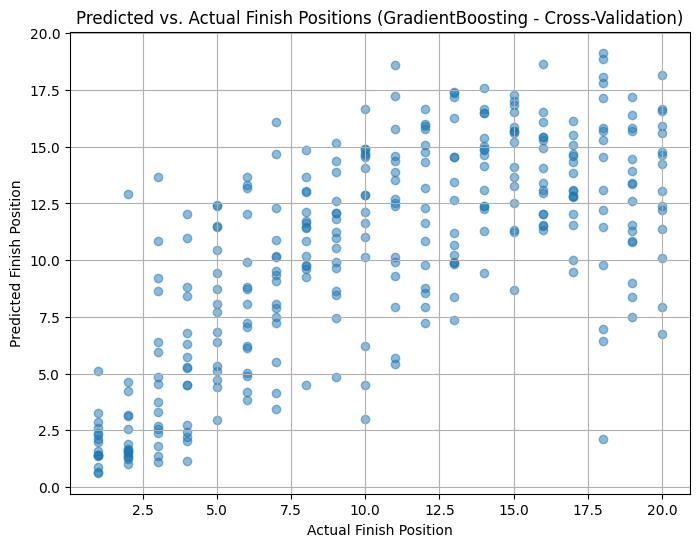

Successfully loaded data for 2025.

--- Renamed grid_pos_upcoming to grid_pos_historical for prediction ---

--- Predicted Race Order ---


,Driver,Team,PredFinish,Win%,Podium%
0,Max Verstappen,Red Bull Racing,2.085444,7.16,28.05
1,Liam Lawson,Racing Bulls,4.411491,23.59,60.57
2,George Russell,Mercedes,4.835136,1.28,8.46
3,Carlos Sainz,Williams,5.003482,0.23,2.43
4,Kimi Antonelli,Mercedes,5.291099,0.01,0.45
5,Alexander Albon,Williams,8.471257,0.00,0.00
6,Oscar Piastri,McLaren,8.967485,0.06,1.15
7,Lewis Hamilton,Ferrari,9.521603,9.52,37.29
8,Isack Hadjar,Racing Bulls,9.926423,1.16,7.30
9,Charles Leclerc,Ferrari,10.377863,8.90,38.86



--- Simulation Summary ---


,Driver,Team,AvgPredPos,Win%,Podium%,Points%
0,Lando Norris,McLaren,3.591194,41.55,76.39,1817.97
1,Liam Lawson,Racing Bulls,4.871540,23.59,60.57,1502.78
2,Charles Leclerc,Ferrari,6.347083,8.90,38.86,1126.61
3,Lewis Hamilton,Ferrari,6.412463,9.52,37.29,1115.80
4,Max Verstappen,Red Bull Racing,7.101944,7.16,28.05,965.11
5,Esteban Ocon,Haas F1 Team,7.670022,4.39,22.04,834.34
6,George Russell,Mercedes,9.416432,1.28,8.46,500.38
7,Fernando Alonso,Aston Martin,9.446412,1.38,8.55,500.30
8,Isack Hadjar,Racing Bulls,9.624303,1.16,7.30,465.86
9,Gabriel Bortoleto,Kick Sauber,10.285339,0.56,5.09,366.87


In [ ]:
year = 2025
grand_prix = "Azerbaijan Grand Prix"
mode = "with-grid"
n_sims = 10000
race_only = False
model_type = 'GradientBoosting'

# Explicitly load qualifying results before calling the prediction function
qualifying_results = load_qualifying_results(year, grand_prix)
print(f"Qualifying results loaded: {not qualifying_results.empty}") # Confirm data loading

pred_df, sims, summary = run_prediction_with_fallback(year, grand_prix, mode=mode, n_sims=n_sims, race_only=race_only, model_type=model_type)

# Display the predicted race order and summary
if pred_df is not None and summary is not None:
    print("\n--- Predicted Race Order ---")
    # Select the relevant columns for race_order from pred_df and merge Win% and Podium% from summary
    race_order = pred_df[['Driver', 'Team', 'PredFinish']].merge(summary[['Driver', 'Win%', 'Podium%']], on='Driver', how='left')
    display(race_order)

    print("\n--- Simulation Summary ---")
    display(summary)
else:
    print("Prediction could not be completed.")

In [ ]:
load_azerbaijan_historical_results(pred_df['Driver'].tolist())

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for race_control_messages. Loading data...
INFO:fastf1.fastf1.req:No cached data found for race_con

,Driver,Team,Year,GP,Position,Status,finish_ok
0,Pierre Gasly,AlphaTauri,2021,Azerbaijan Grand Prix,3.0,Finished,1
1,Charles Leclerc,Ferrari,2021,Azerbaijan Grand Prix,4.0,Finished,1
2,Lando Norris,McLaren,2021,Azerbaijan Grand Prix,5.0,Finished,1
3,Fernando Alonso,Alpine,2021,Azerbaijan Grand Prix,6.0,Finished,1
4,Yuki Tsunoda,AlphaTauri,2021,Azerbaijan Grand Prix,7.0,Finished,1
5,Carlos Sainz,Ferrari,2021,Azerbaijan Grand Prix,8.0,Finished,1
6,Lewis Hamilton,Mercedes,2021,Azerbaijan Grand Prix,15.0,Finished,1
7,George Russell,Williams,2021,Azerbaijan Grand Prix,17.0,Gearbox,1
8,Max Verstappen,Red Bull Racing,2021,Azerbaijan Grand Prix,18.0,Accident,1
9,Lance Stroll,Aston Martin,2021,Azerbaijan Grand Prix,19.0,Accident,1


core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


Attempting to load data for year: 2025, up to Grand Prix: Azerbaijan Grand Prix


req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
req            INFO 	Using cached data for race_control_messages


--- Season Aggregated Data ---


,Driver,Team,num_races,mean_finish_pos,median_finish_pos,best_finish_pos,finish_rate,mean_grid_pos,median_grid_pos,form_score,qual_form
0,Alexander Albon,Williams,16,9.875000,8.5,5.0,0.812500,10.812500,10.5,0.101266,0.092486
1,Carlos Sainz,Williams,16,13.000000,12.5,8.0,0.875000,11.875000,12.0,0.076923,0.084211
2,Charles Leclerc,Ferrari,16,6.687500,4.0,2.0,0.875000,5.062500,5.0,0.149533,0.197531
3,Esteban Ocon,Haas F1 Team,16,12.562500,13.0,5.0,0.937500,14.875000,15.5,0.079602,0.067227
4,Fernando Alonso,Aston Martin,16,12.312500,11.0,5.0,0.750000,10.500000,10.5,0.081218,0.095238
5,Franco Colapinto,Alpine,10,15.700000,15.5,11.0,1.000000,15.800000,16.0,0.063694,0.063291
6,Gabriel Bortoleto,Kick Sauber,16,14.062500,14.5,6.0,0.812500,13.750000,14.5,0.071111,0.072727
7,George Russell,Mercedes,16,4.750000,4.5,1.0,1.000000,4.562500,4.0,0.210526,0.219178
8,Isack Hadjar,Racing Bulls,16,11.500000,11.0,3.0,0.875000,10.187500,10.5,0.086957,0.098160
9,Jack Doohan,Alpine,6,16.333333,16.0,13.0,0.666667,15.500000,15.5,0.061224,0.064516



--- Historical Race Data ---


,Driver,Team,GP,Date,Position,Status,finish_ok,grid_pos
0,Lando Norris,McLaren,Australian Grand Prix,2025-03-16 04:00:00,1.0,Finished,1,1.0
1,Max Verstappen,Red Bull Racing,Australian Grand Prix,2025-03-16 04:00:00,2.0,Finished,1,3.0
2,George Russell,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,3.0,Finished,1,4.0
3,Kimi Antonelli,Mercedes,Australian Grand Prix,2025-03-16 04:00:00,4.0,Finished,1,16.0
4,Alexander Albon,Williams,Australian Grand Prix,2025-03-16 04:00:00,5.0,Finished,1,6.0



--- Roster of Drivers for Upcoming Race (Unique Drivers with Latest Team) ---


,Driver,Team
0,Alexander Albon,Williams
1,Carlos Sainz,Williams
2,Charles Leclerc,Ferrari
3,Esteban Ocon,Haas F1 Team
4,Fernando Alonso,Aston Martin
5,Franco Colapinto,Alpine
6,Gabriel Bortoleto,Kick Sauber
7,George Russell,Mercedes
8,Isack Hadjar,Racing Bulls
10,Kimi Antonelli,Mercedes


Attempting to load qualifying results from: /content/F1 Azerbaijan Qualifying Results.txt
Successfully loaded 20 qualifying results.

--- Qualifying Results ---


,Driver,Team,GridPosition
0,Max Verstappen,Red Bull,1
1,Carlos Sainz,Williams,2
2,Liam Lawson,Racing Bulls,3
3,Kimi Antonelli,Mercedes,4
4,George Russell,Mercedes,5


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Pr


--- Historical Azerbaijan Grand Prix Results ---


,Driver,Team,Year,GP,Position,Status,finish_ok
0,Pierre Gasly,AlphaTauri,2021,Azerbaijan Grand Prix,3.0,Finished,1
1,Charles Leclerc,Ferrari,2021,Azerbaijan Grand Prix,4.0,Finished,1
2,Lando Norris,McLaren,2021,Azerbaijan Grand Prix,5.0,Finished,1
3,Fernando Alonso,Alpine,2021,Azerbaijan Grand Prix,6.0,Finished,1
4,Yuki Tsunoda,AlphaTauri,2021,Azerbaijan Grand Prix,7.0,Finished,1



--- Prediction Frame with Up to Current Features and Latest Team ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin



--- Prediction Frame after Merging form_score and qual_form ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams,0.101266,0.092486
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams,0.076923,0.084211
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari,0.149533,0.197531
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team,0.079602,0.067227
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin,0.081218,0.095238
5,Franco Colapinto,10,15.7000,15.5,11.0,1.0000,15.8000,16.0,Alpine,0.063694,0.063291
6,Gabriel Bortoleto,16,14.0625,14.5,6.0,0.8125,13.7500,14.5,Kick Sauber,0.071111,0.072727
7,George Russell,16,4.7500,4.5,1.0,1.0000,4.5625,4.0,Mercedes,0.210526,0.219178
8,Isack Hadjar,16,11.5000,11.0,3.0,0.8750,10.1875,10.5,Racing Bulls,0.086957,0.098160
9,Kimi Antonelli,16,11.4375,10.5,3.0,0.7500,9.4375,8.5,Mercedes,0.087432,0.105960



--- Prediction Frame after Merging Azerbaijan Historical Results and Calculating Form Score ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate,azerbaijan_form_score
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams,0.101266,0.092486,10.333333,12.0,7.0,1.0,0.287884
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams,0.076923,0.084211,12.750000,13.0,5.0,1.0,0.298839
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari,0.149533,0.197531,7.000000,3.5,2.0,1.0,0.457143
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team,0.079602,0.067227,15.000000,15.0,10.0,1.0,0.263333
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin,0.081218,0.095238,5.750000,6.0,4.0,1.0,0.360145



--- Prediction Frame after Merging Qualifying Results (Upcoming) ---


,Driver,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,Team,form_score,qual_form,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate,azerbaijan_form_score,grid_pos_upcoming
0,Alexander Albon,16,9.8750,8.5,5.0,0.8125,10.8125,10.5,Williams,0.101266,0.092486,10.333333,12.0,7.0,1.0,0.287884,19
1,Carlos Sainz,16,13.0000,12.5,8.0,0.8750,11.8750,12.0,Williams,0.076923,0.084211,12.750000,13.0,5.0,1.0,0.298839,2
2,Charles Leclerc,16,6.6875,4.0,2.0,0.8750,5.0625,5.0,Ferrari,0.149533,0.197531,7.000000,3.5,2.0,1.0,0.457143,10
3,Esteban Ocon,16,12.5625,13.0,5.0,0.9375,14.8750,15.5,Haas F1 Team,0.079602,0.067227,15.000000,15.0,10.0,1.0,0.263333,20
4,Fernando Alonso,16,12.3125,11.0,5.0,0.7500,10.5000,10.5,Aston Martin,0.081218,0.095238,5.750000,6.0,4.0,1.0,0.360145,11


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for race_control_messages
INFO:fastf1.fastf1.req:Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Pr


--- Initial Training Data ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.000000,5.0,5.0,1.000000,6.000000,6.0,6.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.000000,6.0,5.0,1.000000,8.000000,8.0,10.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.000000,7.0,5.0,1.000000,8.333333,9.0,9.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.250000,8.0,5.0,1.000000,10.000000,9.5,15.0
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.400000,9.0,5.0,1.000000,10.200000,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
314,Yuki Tsunoda,Red Bull Racing,British Grand Prix,15.0,12,13.416667,12.5,9.0,0.916667,12.833333,11.5,11.0
315,Yuki Tsunoda,Red Bull Racing,Belgian Grand Prix,13.0,13,13.384615,13.0,9.0,0.923077,12.384615,11.0,7.0
316,Yuki Tsunoda,Red Bull Racing,Hungarian Grand Prix,17.0,14,13.642857,13.0,9.0,0.928571,12.928571,11.5,20.0
317,Yuki Tsunoda,Red Bull Racing,Dutch Grand Prix,9.0,15,13.333333,13.0,9.0,0.933333,12.866667,12.0,12.0



--- Training Data after Merging season_agg Features ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical,form_score,qual_form,azerbaijan_form_score
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,6.0,0.101266,0.092486,0.287884
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,10.0,0.101266,0.092486,0.287884
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,9.0,0.101266,0.092486,0.287884
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,15.0,0.101266,0.092486,0.287884
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,11.0,0.101266,0.092486,0.287884



--- Training Data after Merging Azerbaijan Historical Results (Aggregated) ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical,form_score,qual_form,azerbaijan_form_score,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,6.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,10.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,9.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,15.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,11.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0



--- Final Training Data (after dropping NaNs in y_finish_pos) ---


,Driver,Team,GP,y_finish_pos,num_races,mean_finish_up_to_current,median_finish_up_to_current,best_finish_up_to_current,finish_rate_up_to_current,mean_grid_pos_up_to_current,median_grid_pos_up_to_current,grid_pos_historical,form_score,qual_form,azerbaijan_form_score,azerbaijan_avg_finish,azerbaijan_median_finish,azerbaijan_best_finish,azerbaijan_finish_rate
0,Alexander Albon,Williams,Australian Grand Prix,5.0,1,5.00,5.0,5.0,1.0,6.000000,6.0,6.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
1,Alexander Albon,Williams,Chinese Grand Prix,7.0,2,6.00,6.0,5.0,1.0,8.000000,8.0,10.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
2,Alexander Albon,Williams,Japanese Grand Prix,9.0,3,7.00,7.0,5.0,1.0,8.333333,9.0,9.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
3,Alexander Albon,Williams,Bahrain Grand Prix,12.0,4,8.25,8.0,5.0,1.0,10.000000,9.5,15.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0
4,Alexander Albon,Williams,Saudi Arabian Grand Prix,9.0,5,8.40,9.0,5.0,1.0,10.200000,10.0,11.0,0.101266,0.092486,0.287884,10.333333,12.0,7.0,1.0



--- Feature columns for training ---
Index(['num_races', 'mean_finish_up_to_current', 'median_finish_up_to_current',
       'best_finish_up_to_current', 'finish_rate_up_to_current',
       'mean_grid_pos_up_to_current', 'median_grid_pos_up_to_current',
       'grid_pos_historical', 'form_score', 'qual_form',
       'azerbaijan_form_score', 'azerbaijan_avg_finish',
       'azerbaijan_median_finish', 'azerbaijan_best_finish',
       'azerbaijan_finish_rate'],
      dtype='object')
CV MAE (RandomForest): 3.071 positions
CV RMSE (RandomForest): 3.980 positions
CV R-squared (RandomForest): 0.521


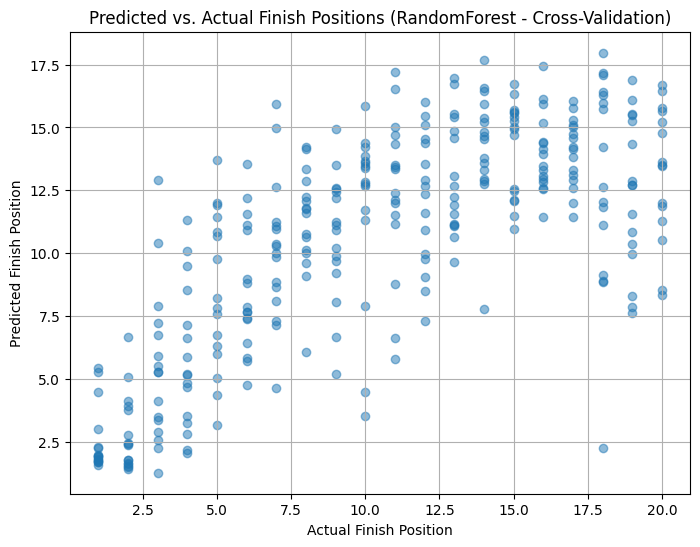

Successfully loaded data for 2025.

--- Renamed grid_pos_upcoming to grid_pos_historical for prediction ---

--- Predicted Race Order (Random Forest) ---


,Driver,Team,PredFinish,Win%,Podium%
0,Max Verstappen,Red Bull Racing,3.504792,9.22,29.25
1,George Russell,Mercedes,5.501871,16.32,42.76
2,Liam Lawson,Racing Bulls,7.106454,4.29,16.33
3,Kimi Antonelli,Mercedes,7.296594,0.68,4.01
4,Carlos Sainz,Williams,7.967486,1.30,6.96
5,Oscar Piastri,McLaren,8.276180,0.01,0.27
6,Lewis Hamilton,Ferrari,9.757764,0.06,0.58
7,Alexander Albon,Williams,10.205102,9.96,31.07
8,Yuki Tsunoda,Red Bull Racing,10.530073,1.32,6.45
9,Charles Leclerc,Ferrari,11.046105,13.12,36.64



--- Simulation Summary (Random Forest) ---


,Driver,Team,AvgPredPos,Win%,Podium%,Points%
0,Esteban Ocon,Haas F1 Team,6.805431,22.46,51.68,1334.71
1,George Russell,Mercedes,7.385366,16.32,42.76,1169.08
2,Charles Leclerc,Ferrari,7.745903,13.12,36.64,1062.92
3,Fernando Alonso,Aston Martin,7.852885,12.58,35.03,1036.94
4,Alexander Albon,Williams,8.128973,9.96,31.07,951.46
5,Max Verstappen,Red Bull Racing,8.362403,9.22,29.25,905.03
6,Gabriel Bortoleto,Kick Sauber,9.175590,4.99,18.63,688.63
7,Liam Lawson,Racing Bulls,9.417320,4.29,16.33,637.92
8,Yuki Tsunoda,Red Bull Racing,10.760293,1.32,6.45,359.53
9,Carlos Sainz,Williams,10.762405,1.30,6.96,365.37


In [ ]:
# Run the prediction process with Random Forest model
pred_df_rf, sims_rf, summary_rf = run_prediction_with_fallback(2025, "Azerbaijan Grand Prix", mode="with-grid", n_sims=10000, race_only=False, model_type='RandomForest')

# Display the predicted race order and summary for Random Forest
print("\n--- Predicted Race Order (Random Forest) ---")
# Select the relevant columns for race_order_rf and merge Win% and Podium% from summary_rf
race_order_rf = pred_df_rf[['Driver', 'Team', 'PredFinish']].merge(summary_rf[['Driver', 'Win%', 'Podium%']], on='Driver', how='left')
display(race_order_rf)

print("\n--- Simulation Summary (Random Forest) ---")
display(summary_rf)

In [ ]:
# Display the predicted race order and summary for Random Forest
print("\n--- Predicted Race Order (Random Forest) ---")
display(race_order_rf)

print("\n--- Simulation Summary (Random Forest) ---")
display(summary_rf)


--- Predicted Race Order (Random Forest) ---


,Driver,Team,PredFinish,Win%,Podium%
0,Lando Norris,McLaren,1.529968,0.00,0.26
1,Oscar Piastri,McLaren,1.925681,0.00,0.06
2,Charles Leclerc,Ferrari,5.678352,9.60,40.88
3,George Russell,Mercedes,5.900855,0.02,0.28
4,Max Verstappen,Red Bull Racing,6.901627,0.58,3.86
5,Lewis Hamilton,Ferrari,7.838590,0.00,0.00
6,Liam Lawson,Racing Bulls,9.609663,0.10,1.74
7,Fernando Alonso,Aston Martin,10.426645,8.52,36.48
8,Lance Stroll,Aston Martin,10.803416,0.04,0.94
9,Nico Hulkenberg,Kick Sauber,11.678895,0.06,1.50



--- Simulation Summary (Random Forest) ---


,Driver,Team,AvgPredPos,Win%,Podium%,Points%,ExpPos
0,Kimi Antonelli,Mercedes,2.681086,46.34,82.34,1914.94,0.0
1,Carlos Sainz,Williams,2.893511,25.36,79.68,1726.12,0.0
2,Charles Leclerc,Ferrari,5.757463,9.60,40.88,1179.50,0.0
3,Fernando Alonso,Aston Martin,6.026642,8.52,36.48,1128.94,0.0
4,Esteban Ocon,Haas F1 Team,6.998179,5.02,23.98,939.20,0.0
5,Isack Hadjar,Racing Bulls,7.809512,3.12,16.12,795.32,0.0
6,Alexander Albon,Williams,9.507075,0.92,6.68,522.72,0.0
7,Max Verstappen,Red Bull Racing,10.453926,0.58,3.86,390.22,0.0
8,Gabriel Bortoleto,Kick Sauber,10.849011,0.24,3.06,328.68,0.0
9,Pierre Gasly,Alpine,11.728373,0.08,1.84,241.96,0.0


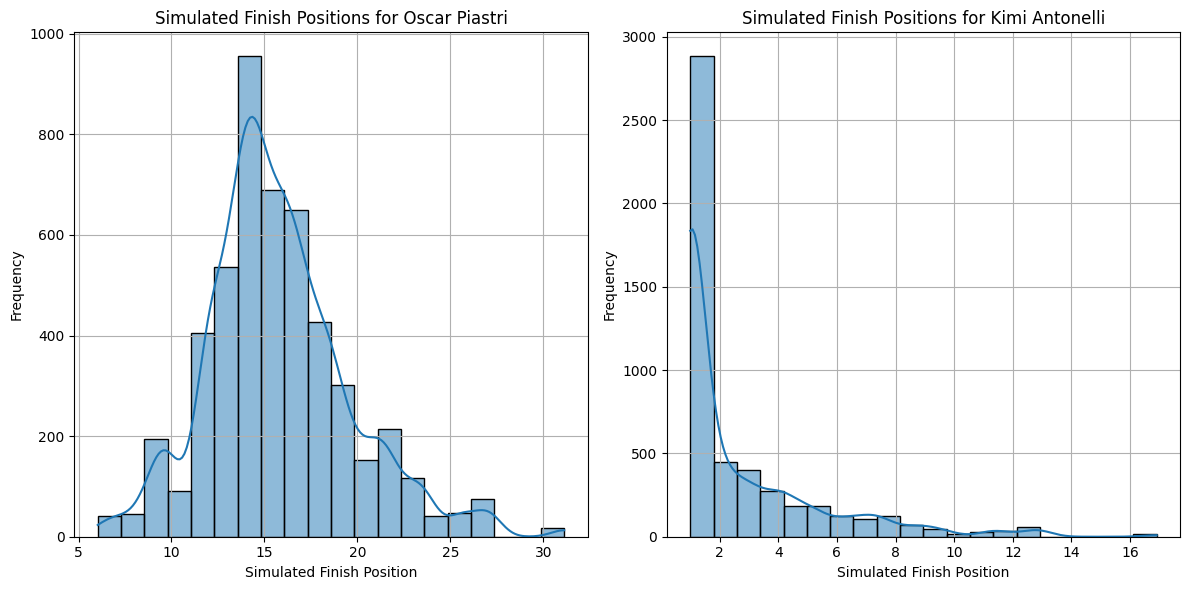

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'sims' and 'pred_df' are available from the last run of run_prediction_with_fallback
# If not, you would need to re-run run_prediction_with_fallback first.

# Get the simulated finish positions for all drivers
simulated_finish_positions = pd.DataFrame(sims_rf, columns=pred_df_rf['Driver'])

# Select the drivers of interest
drivers_to_visualize = ['Oscar Piastri', 'Kimi Antonelli']

plt.figure(figsize=(12, 6))

for i, driver in enumerate(drivers_to_visualize):
    if driver in simulated_finish_positions.columns:
        plt.subplot(1, len(drivers_to_visualize), i + 1)
        sns.histplot(simulated_finish_positions[driver], kde=True, bins=20)
        plt.xlabel("Simulated Finish Position")
        plt.ylabel("Frequency")
        plt.title(f"Simulated Finish Positions for {driver}")
        plt.grid(True)
    else:
        print(f"Driver '{driver}' not found in simulated data.")

plt.tight_layout()
plt.show()